# Визуализация датафрейма с суицидами по миру

In [170]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import json
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import brewer
from bokeh.models import BoxAnnotation,Label, LabelSet

In [171]:
suicides = pd.read_csv('master.csv')
suicides =suicides[suicides['year'] < 2016]

Как он выглядит

In [172]:
suicides.head(5)

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


Тренды суицидов по миру

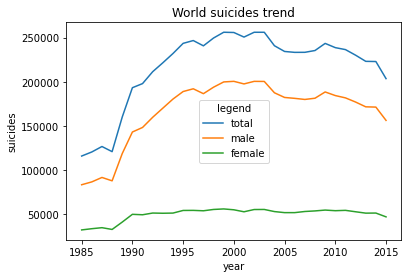

In [173]:
fig, ax = plt.subplots()
g1 = pd.pivot_table(suicides.groupby(['year','sex']).sum().reset_index()[['year','sex','suicides_no']],index='year',columns='sex',values='suicides_no').reset_index()
g = suicides.groupby(['year']).sum().reset_index()[['year','suicides_no']].rename(columns={'suicides_no': 'suicides'})
ax.plot(g['year'], g['suicides'],label='total')
ax.plot(g1['year'], g1['male'],label='male')
ax.plot(g1['year'], g1['female'],label='female')
ax.set(xlabel='year', ylabel='suicides',
       title='World suicides trend')
plt.legend(title='legend')

Женщины раз в 5 суицидят реже мужчин

ещё раз этот же график но по другому построеный

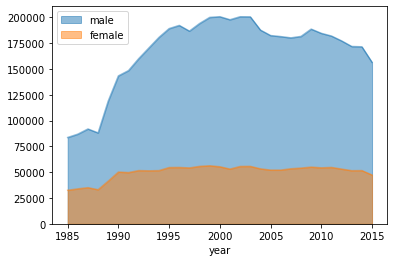

In [175]:
a = suicides[['year','sex','suicides_no']].groupby(['year','sex']).sum().reset_index()
b  = a[a['sex'] == 'female'][['year','suicides_no']]

pd.merge(a[a['sex'] == 'male'][['year','suicides_no']], b,on=['year'],how='left').rename(
    columns={"suicides_no_x": "male", "suicides_no_y": "female"}).plot.area(stacked=False,x='year')

А теперь посмотрим разрез какой-нибудь страны по возрастным категриям, напрмер Франция(можно смотреть любой я сделал функцией)

In [178]:
def plot_ages(suicides,country):
    suicides[suicides["country"] == country]
    figure, axes = plt.subplots(3,2, figsize=(10,10), tight_layout=True)
    age_categories = ['5-14 years','15-24 years','25-34 years','35-54 years','55-74 years','75+ years']

    for i in range(len(age_categories)):
        axes.flatten()[i].set_title(age_categories[i])

        c = pd.pivot_table(
            suicides[(suicides["age"] == age_categories[i]) & (suicides["country"] == country)][['year','suicides/100k pop','sex']],
            index='year',columns='sex',values='suicides/100k pop').reset_index()
        c.plot.area(stacked=False,x='year',ax=axes.flatten()[i])

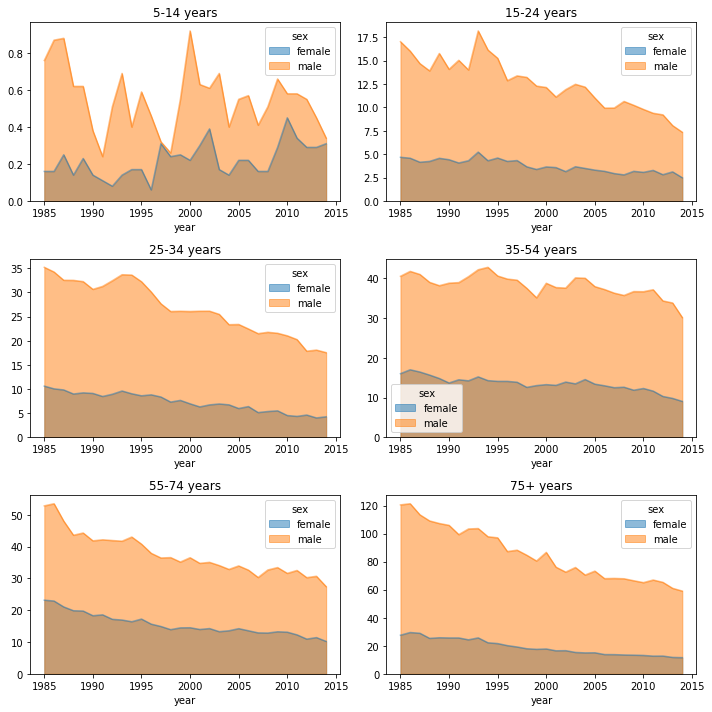

In [184]:
plot_ages(suicides,'France')

Пожилые люди во франции, как и люди с 15 до 24х, стали совершать самоубийства реже

In [195]:
suicides['generation'].unique()

array(['Generation X', 'Silent', 'G.I. Generation', 'Boomers',
       'Millenials', 'Generation Z'], dtype=object)

[Text(0, 0.5, 'suicides/100k pop'),
 Text(0.5, 0, 'gdp per capita ($)'),
 Text(0.5, 1.0, 'Gpd corelation')]

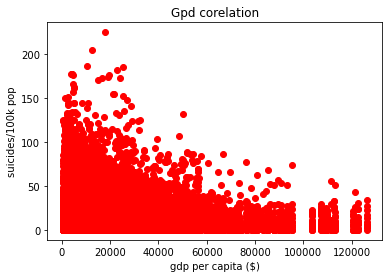

In [193]:
fig, ax = plt.subplots()
ax.plot(suicides['gdp_per_capita ($)'], suicides['suicides/100k pop'], 'ro')
ax.set(xlabel='gdp per capita ($)', ylabel='suicides/100k pop',
       title='Gpd corelation')

Теперь можно настрить срез и посмотреть на самоубийства на карте мира

In [196]:
def Plot_world_map(df,column,year=None,sex=None,age=None,generation=None):
    shapefile = '110m_cultural/ne_110m_admin_0_countries.shp'
    #Read shapefile using Geopandas
    gdf = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]
    #Rename columns.
    gdf.columns = ['country', 'country_code', 'geometry']
    #Drop row corresponding to 'Antarctica'
    gdf = gdf.drop(gdf.index[159])
    if year != None:
        df = df[df['year'] == year]
    if sex != None:
        df = df[df['sex'] == sex]
    if age != None:
        df = df[df['age'] == age]
    if generation != None:
        df = df[df['generation'] == generation]
    df = df.groupby(['country','year','sex','age','generation']).sum().reset_index()
    merged = gdf.merge(df, on = 'country', how = 'left')
    #merged[column] = merged[column].fillna(10)
    #Read data to json.
    merged_json = json.loads(merged.to_json())
    #Convert to String like object.
    json_data = json.dumps(merged_json)

    legend_map = {}
    for i in range(9):
        a = min(df[column].unique())//1 + (
            (max(df[column].unique()) - min(df[column].unique())) //9)*i
        legend_map.update({str(a):str(a)})
    #Input GeoJSON source that contains features for plotting.
    geosource = GeoJSONDataSource(geojson = json_data)
    #Define a sequential multi-hue color palette.
    palette = brewer['OrRd'][8]
    #Reverse color order so that dark is highest obesity.
    palette = palette[::-1]
    #Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
    color_mapper = LinearColorMapper(palette = palette, low = 0, high = max(df[column].unique()))
    #Define custom tick labels for color bar.
    tick_labels = legend_map#{'0': '0%', '5': '5%', '10':'10%', '15':'15%', '20':'20%', '25':'25%', '30':'30%','35':'35%', '40': '>40%'}
    #Create color bar. 
    color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
    border_line_color=None,location = (0,0), orientation = 'horizontal', major_label_overrides = tick_labels)
    #Create figure object.
    p = figure(title = 'Suicides in '+str(year)+' '+str(column), plot_height = 600 , plot_width = 950, toolbar_location = None)
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    #Add patch renderer to figure. 
    p.patches('xs','ys', source = geosource,fill_color = {'field' :column, 'transform' : color_mapper},
              line_color = 'black', line_width = 0.25, fill_alpha = 1)
    #Specify figure layout.
    p.add_layout(color_bar, 'below')
    #Display figure inline in Jupyter Notebook.
    output_notebook()
    #Display figure.
    #legend(title='legend')
    #low_box = BoxAnnotation(top=80, fill_alpha=0.1, fill_color='red')
    #p.add_layout(low_box)
    label1 = Label(x=70, y=-20, x_units='screen', text='Filters:', render_mode='css',
      border_line_color='black', border_line_alpha=1.0,
      background_fill_color='white', background_fill_alpha=1.0)
    label2 = Label(x=70, y=-27, x_units='screen', text='sex:'+str(sex), render_mode='css',
      border_line_color='black', border_line_alpha=1.0,
      background_fill_color='white', background_fill_alpha=1.0)
    label3 = Label(x=70, y=-34, x_units='screen', text='age group:'+str(age), render_mode='css',
      border_line_color='black', border_line_alpha=1.0,
      background_fill_color='white', background_fill_alpha=1.0)
    label4 = Label(x=70, y=-41, x_units='screen', text='generation:' + str(generation), render_mode='css',
      border_line_color='black', border_line_alpha=1.0,
      background_fill_color='white', background_fill_alpha=1.0)
    p.add_layout(label1)
    p.add_layout(label2)
    p.add_layout(label3)
    p.add_layout(label4)
    show(p)

Plot_world_map(df,column,year=None,sex=None,age=None,generation=None)
- column - suicides/100k pop or suicides_no
- year - from 1986 to 2015
- sex - male/female
- age - {'15-24 years', '35-54 years', '75+ years', '25-34 years','55-74 years', '5-14 years'}
- generation - {'Generation X', 'Silent', 'G.I. Generation', 'Boomers','Millenials', 'Generation Z'}

In [197]:
Plot_world_map(suicides,'suicides/100k pop',year=1999,generation='Boomers')

Loading BokehJS ...